In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import imageio
import cv2
import glob
import os
from shutil import rmtree
from random import random
from uuid import uuid4
from os import path
from IPython.display import display, clear_output
from PIL import Image, ImageDraw

In [3]:
ignored = {"pje", "lattes", "rfb", "tjrs", "trt3", "nfesjppr"}

input_dir = "dataset"
input_dirs = [f.path for f in os.scandir(input_dir) if f.is_dir() and f.name not in ignored]
rectanglesDir = "rects"

output_dir = "lettersDataset_biggerMargin"

dataset\cadesp\2f3c.png


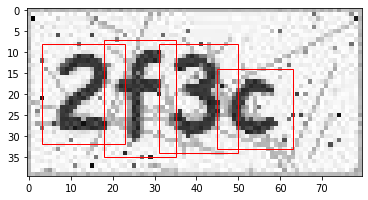

dataset\caixa\1y5nf.gif


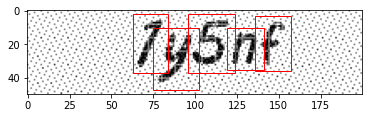

dataset\nfe\09aib.png


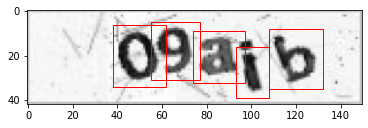

dataset\rsc\2yma.png


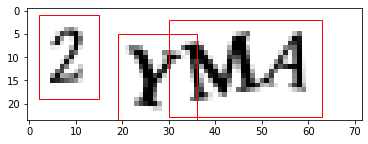

dataset\sefazsp\08p63.jpg


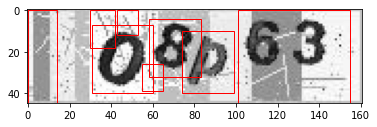

dataset\sintegrarj\2vamr.png


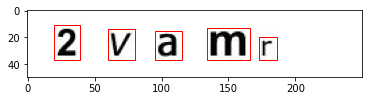

In [9]:
for directory in input_dirs:
    captcha_image_files = glob.glob(os.path.join(directory, "*"))
    
    # for image_path in captcha_image_files:
    image_path = captcha_image_files[301]
    image = cv2.imread(image_path)

    if image is None:
        image = imageio.mimread(image_path)

        # ignore gifs with more than one frame
        if len(image) > 1:
            continue

        # convert form RGB to BGR 
        image = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # blur = cv2.medianBlur(gray, 1)
    # blur = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, np.ones((2,2), np.uint8))
    tr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    margin = 3

    contours = [cv2.boundingRect(contour) for contour in cv2.findContours(tr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]
    contours = [(x, y, w, h) for (x, y, w, h) in contours if w > 2 and h > 5 and w/h < 3 and h/w < 8]
    contours = [(max(x - margin, 0), max(y - margin, 0), w + 2*margin, h + 2*margin) for (x, y, w, h) in contours]

    fig, ax = plt.subplots()

    ax.imshow(gray, cmap='gray')

    # for (x, y, width, heigth) in contours:
    #     if width / heigth > 1.05:
    #         # This contour is too wide to be a single letter!
    #         # Split it in half into two letter regions!
    #         half_width = int(width / 2)
    #         regions.append((x, y, half_width, heigth))
    #         regions.append((x + half_width, y, half_width, heigth))
    #     else:
    #         # This is a normal letter by itself
    #         regions.append((x, y, width, heigth))

    for (x, y, w, h) in contours:
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))

    print(image_path)
    plt.show()

In [5]:
def intersectionArea(a, b):
    (x1, y1, w1, h1) = a
    (x2, y2, w2, h2) = b

    dx = min(x1 + w1, x2 + w2) - max(x1, x2)
    dy = min(y1 + h1, y2 + h2) - max(y1, x2)
    if (dx >= 0) and (dy >= 0):
        return dx * dy

In [6]:
def areAnyRegionsOverlapping(regions):
    for (i, region1) in enumerate(regions):
        for (j, region2) in enumerate(regions):
            if i == j:
                continue
            
            area1 = region1[2] * region1[3]
            area2 = region2[2] * region2[3]
            inter = intersectionArea(region1, region2)

            if inter is not None and inter != 0 and (area1/inter < 3 or area2/inter < 3):
                return True

    return False


In [7]:
images = [glob.glob(os.path.join(directory, "*")) for directory in input_dirs]
images = [item for sublist in images for item in sublist]
total = len(images)

In [1]:
failedImages = 0
correctImages = 0

if path.exists(output_dir):
    print("Removing old dataset...")
    rmtree(output_dir)
    print("Removed")

totalProcessed = 0
for directory in input_dirs:
    for image_path in glob.glob(os.path.join(directory, "*")):
        totalProcessed = totalProcessed + 1
        clear_output(wait=True)
        display('Processing image ' + str(totalProcessed) + ' of ' + str(total) + ' ({:.2f}%)'.format(totalProcessed/total*100))
        image = cv2.imread(image_path)

        if image is None:
            image = imageio.mimread(image_path)

            # ignore gifs with more than one frame
            if len(image) > 1:
                continue

            # convert form RGB to BGR 
            image = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # blur = cv2.medianBlur(gray, 1)
        # blur = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, np.ones((2,2), np.uint8))
        tr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        margin = 5
        contours = [ cv2.boundingRect(contour) for contour in cv2.findContours(tr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]
        contours = [(x, y, w, h) for (x, y, w, h) in contours if w > 2 and h > 5 and w/h < 3 and h/w < 8]
        contours = [(max(x - margin, 0), max(y - margin, 0), w + 2*margin, h + 2*margin) for (x, y, w, h) in contours]

        regions = []

        regions = sorted(contours, key=lambda x: x[0])

        labels = path.basename(path.splitext(image_path)[0])

        if (len(labels) != len(regions)):
            failedImages = failedImages + 1
            continue

        if areAnyRegionsOverlapping(regions):
            print("Two regions are overlapping, discarding image")
            continue

        
        # rectangled = image.copy()
        for ((x, y, width, height), label) in zip(regions, labels):
            letter = gray[y:y + height, x:x + width]

            actualHeight, actualWidth = letter.shape

            if len(letter) == 0 or actualWidth == 0 or actualHeight == 0:
                continue

            if max(actualHeight, actualWidth)/min(actualHeight, actualWidth) > 3:
                print("Letter skipped due to invalid aspect ratio")
                continue

            targetDir = "train" if random() < 0.8 else "test"

            # Get the folder to save the image in
            save_path = os.path.join(output_dir, targetDir, label)

            # if the output directory does not exist, create it
            if not path.exists(save_path):
                os.makedirs(save_path)

            p = os.path.join(save_path, "{}.png".format(uuid4()))
            
            try:
                cv2.imwrite(p, letter)
                # rectangled = cv2.rectangle(rectangled, (x - margin, y - margin), (x + margin + width, y + height + margin), list(np.random.random(size=3) * 256), 1)
            except:
                print("Letter saving failed", p, letter)

        # savePath = image_path.replace(input_dir, rectanglesDir)

        # if not path.exists(path.dirname(savePath)):
        #     os.makedirs(path.dirname(savePath))

        # ext = path.splitext(savePath)[1]

        # if ext == ".gif":
        #     savePath = savePath.replace(ext, ".png")

        # try:
        #     cv2.imwrite(savePath, rectangled)
        # except:
        #     print("Failed to save rectangled image for {}".format(image_path), rectangled)
    
print("Processed {} images".format(correctImages))
print("Failed to process {} images".format(failedImages))


NameError: name 'path' is not defined